# TfIdf-Clusters+LDA

In [98]:
# Install
#!pip install -r requirements.txt
#pip install numpy==1.20.0
#pip install pandas
#pip install yellowbrick

C:\Users\kater\anaconda3\envs\covid\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Data

In [2]:
# Importing prepared dataset
import pickle
input = open('my_corpus.pql', 'rb')
obj = pickle.load(input)
input.close()

corpus = obj['corpus']
all_words = obj['all_words']

In [3]:
# TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0.001, use_idf=True, ngram_range=(1,3))
                            #max_df=0.8, max_features=10000
tfidf_matrix = vectorizer.fit_transform(corpus).astype('float16')
terms = vectorizer.get_feature_names()

# K-Means

In [ ]:
#!pip install clusteval

In [ ]:
'''# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(tfidf_matrix.astype('float16'))
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 25), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()'''

In [ ]:
# Silhouette method to find the optimal number of clusters
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

sil = []

for K in range(2, 50):
  kmeans = KMeans(n_clusters = K).fit(tfidf_matrix)  
  preds = kmeans.fit_predict(tfidf_matrix)
  sil.append(silhouette_score(tfidf_matrix, preds, metric = 'euclidean'))


plt.plot(range(2, 50), sil)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sil')
plt.show()

for i in range(len(sil)):
 print(str(i+2) +":"+ str(sil[i]))

In [4]:
# Number of Clusters
k = 8

In [5]:
# K-means clustering
from sklearn.cluster import KMeans

km = KMeans(n_clusters = k).fit(tfidf_matrix)

### Clusters descriptions

In [6]:
from nltk import FreqDist

In [7]:
def descriptions(name, labels):
    # Reactions
    posts = { 'corpus': corpus, 'cluster': labels }
    posts = pd.DataFrame(posts)
    words_from_clusters = posts.groupby(['cluster'])['corpus'].apply(lambda x: "%s" % ' '.join(x))
    
    names = []
    for cluster in words_from_clusters:
            words_freq = FreqDist(cluster.split(' '))
            names.append(words_freq.most_common(1)[0][0])
            print('Cluster: ', cluster.title)
            print('Most popular words: ', words_freq.most_common(10))
            print('Total number of unique words: ', len(words_freq))
            print('\n')
            
    # Clusters cores
    cores = pd.DataFrame({'names':names})
    cores['shares'] = (posts.groupby(['cluster']).count()/len(labels)*100).round(2)
    print(cores)

In [8]:
clusters = pd.DataFrame(km.labels_.tolist())
clusters.columns = ['kmeans']
descriptions('kmeans', km.labels_.tolist())

Cluster:  <built-in method title of str object at 0x00000137556E5040>
Most popular words:  [('міністр', 1061), ('система', 735), ('організація', 725), ('питання', 723), ('орган', 643), ('закон', 605), ('управління', 504), ('населення', 470), ('технічний', 446), ('забезпечення', 438)]
Total number of unique words:  15247


Cluster:  <built-in method title of str object at 0x000001374B7A2D60>
Most popular words:  [('найкращий', 1132), ('фільм', 1068), ('премія', 807), ('режисер', 509), ('приз', 350), ('номінація', 250), ('чоловічий', 151), ('другий', 136), ('фестиваль', 133), ('кіно', 127)]
Total number of unique words:  6191


Cluster:  <built-in method title of str object at 0x00000137558E7040>
Most popular words:  [('мова', 2146), ('місце', 1166), ('неуточнений', 1025), ('полк', 661), ('святий', 627), ('іван', 575), ('назва', 575), ('колишній', 556), ('дивізія', 552), ('серія', 540)]
Total number of unique words:  88921


Cluster:  <built-in method title of str object at 0x000001374B7

## LDA

In [9]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components = k,           # Number of topics
                                      max_iter = 20,               # Max learning iterations
                                      random_state = 100,          # Random state
                                      batch_size = 128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(tfidf_matrix)

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(tfidf_matrix))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(tfidf_matrix))

Log Likelihood:  -325867.6237587085
Perplexity:  64208.69474917862


In [10]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,місце,файл,північний,мова,святий,острів,західний,річка,південний,східний
Topic 1,категорія,джон,роберт,джеймс,девід,майкл,вільям,орден,джордж,граф
Topic 2,категорія,повіт,герб,категорія футболіст,фортепіано,футболіст,прапор,грец,категорія гравець,футбольний легіонер
Topic 3,найкращий,фільм,приз,премія,режисер,притока,чоловічий,номінація,закадровий,закадровий озвучення
Topic 4,організація,система,питання,вулиця,орган,управління,закон,сільський,міністр,технічний
Topic 5,лівий,право,сільрада,особистий внесок,орден,утриманець,династія,тура,особистий,внесок
Topic 6,неуточнений,порушення,виключаючи,ураження,класифікований,зображення,гострий,новоутворення,тіло,хронічний
Topic 7,олександр,іван,володимир,микола,іванович,михайло,василь,сергій,юрій,андрій


### LDA Visualizing

In [ ]:
#!pip install pyldavis

In [11]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

panel = pyLDAvis.sklearn.prepare(lda_model, tfidf_matrix, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
7     -108.958252 -208.941483       1        1  39.528229
4      186.487061  -98.103249       2        1  17.097181
1       19.245832  160.858780       3        1  13.454322
0      170.658829   75.445076       4        1  12.562795
6       -1.386411  -35.043739       5        1   6.892922
3     -145.800095  106.944611       6        1   3.862344
2       64.834541 -221.825272       7        1   3.617874
5     -196.906036  -58.990913       8        1   2.984333, topic_info=               Term       Freq      Total Category  logprob  loglift
7529      категорія  29.000000  29.000000  Default  30.0000  30.0000
14776        премія  23.000000  23.000000  Default  29.0000  29.0000
11523     найкращий  13.000000  13.000000  Default  28.0000  28.0000
12638     олександр  50.000000  50.000000  Default  27.0000  27.0000
19992         фільм  22.000000  22.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
21924     імператор   0.907428   4.338216   Topic8  -6.8754   1.9472
1068   багаторічний   0.750398   2.448873   Topic8  -7.0654   2.3290
11072        мудрий   0.660328   1.928233   Topic8  -7.1932   2.4402
8008          князь   0.693668  10.329469   Topic8  -7.1440   0.8110
5780           діти   0.663538  10.441550   Topic8  -7.1884   0.7558

[395 rows x 6 columns], token_table=       Topic      Freq                 Term
term                                       
202        4  0.844703                 азія
267        6  0.848738  академія наука урср
483        1  0.918629        американський
483        3  0.051035        американський
519        8  0.834267                ананд
...      ...       ...                  ...
22182      3  0.168350              іспанія
22182      4  0.673398              іспанія
22232      1  0.124331               італія
22232      3  0.124331               італія
22232      4  0.621654               італія

[512 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 2, 1, 7, 4, 3, 6])

### Saving results

In [12]:
p = pyLDAvis.sklearn.prepare(lda_model, tfidf_matrix, vectorizer, mds='tsne')
pyLDAvis.save_html(p, 'lda-21.html')

C:\Users\kater\anaconda3\envs\covid\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## LDA-K-means

In [13]:
# K-means clustering
kmLDA = KMeans(n_clusters = k)
kmLDA.fit(lda_output)

C:\Users\kater\anaconda3\envs\covid\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KMeans()

In [14]:
clusters['kmLDA'] = kmLDA.labels_.tolist()
descriptions('kmLDA', kmLDA.labels_.tolist())

C:\Users\kater\anaconda3\envs\covid\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cluster:  <built-in method title of str object at 0x000001372CA7F040>
Most popular words:  [('мова', 1960), ('файл', 971), ('місце', 861), ('сільський', 435), ('святий', 417), ('північний', 365), ('міна', 332), ('західний', 314), ('річка', 312), ('східний', 302)]
Total number of unique words:  30960


Cluster:  <built-in method title of str object at 0x0000013755BF9040>
Most popular words:  [('олександр', 1998), ('іван', 1831), ('микола', 1753), ('володимир', 1723), ('іванович', 1517), ('михайло', 1269), ('василь', 1260), ('наука', 1138), ('сергій', 1108), ('петро', 964)]
Total number of unique words:  41096


Cluster:  <built-in method title of str object at 0x0000013756F4C040>
Most popular words:  [('сільський', 884), ('вулиця', 705), ('організація', 612), ('система', 610), ('закон', 596), ('орган', 566), ('питання', 511), ('управління', 478), ('полк', 462), ('харківський', 457)]
Total number of unique words:  18308


Cluster:  <built-in method title of str object at 0x000001374B787F

In [43]:
LDA = pd.DataFrame(lda_output, columns = ['geo','noble','football','cinema','law','history','health','name'])
kmLDA_centers = pd.DataFrame(kmLDA.cluster_centers_, columns = ['geo','noble','football','cinema','law','history','health','name']).round(2)

C:\Users\kater\anaconda3\envs\covid\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
def plot_2d_cores(X, label_list_cluster, cores):
    plt.figure(figsize=(7, 7))
    plt.subplots_adjust(bottom=0.1)
    c = label_list_cluster
    n = ('orange','green','yellow','blue','black','red','purple','white')
    plt.scatter(X[:, 0], X[:, 1], c=c, cmap='rainbow', label='True Position')
    plt.scatter(cores[:, 0], cores[:, 1], c=n, s = 500, marker = '*')
    plt.show()

C:\Users\kater\anaconda3\envs\covid\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\kater\anaconda3\envs\covid\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


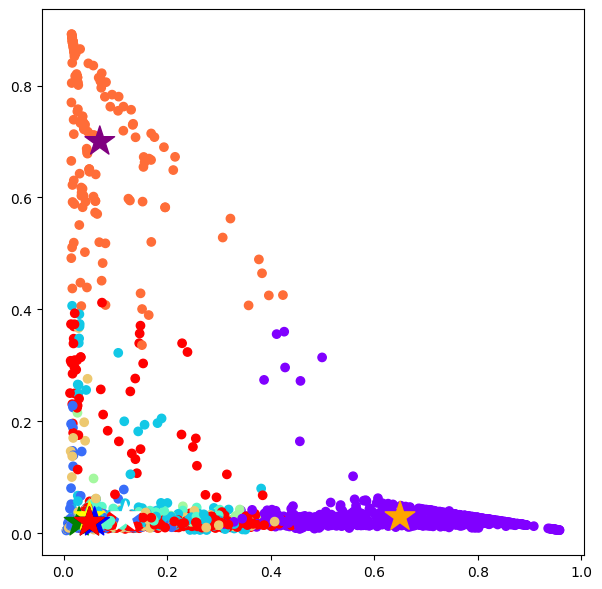

In [46]:
plot_2d_cores(LDA[['geo','football']].to_numpy(),kmLDA.labels_.tolist(),kmLDA_centers[['geo','football']].to_numpy())

## LDA AgglomerativeClustering

C:\Users\kater\anaconda3\envs\covid\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


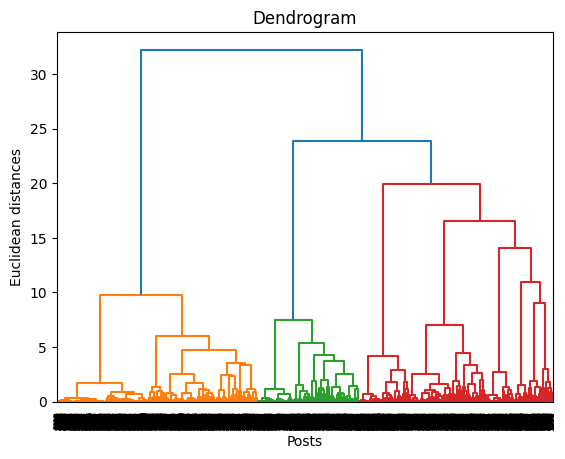

In [15]:
# Using the dendrogram to find the optimal number of clusters
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(lda_output, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Posts')
plt.ylabel('Euclidean distances')
plt.show()

In [16]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean', linkage = 'ward').fit_predict(lda_output)

C:\Users\kater\anaconda3\envs\covid\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
clusters['agLDA'] = hc
descriptions('agLDA', hc)

C:\Users\kater\anaconda3\envs\covid\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cluster:  <built-in method title of str object at 0x0000013763A2A010>
Most popular words:  [('найкращий', 900), ('лівий', 697), ('право', 690), ('фільм', 601), ('сільрада', 487), ('премія', 472), ('притока', 384), ('закадровий', 344), ('озвучення', 329), ('чоловічий', 324)]
Total number of unique words:  9010


Cluster:  <built-in method title of str object at 0x000001375B618040>
Most popular words:  [('мова', 1987), ('файл', 1002), ('місце', 886), ('святий', 471), ('сільський', 382), ('північний', 366), ('міна', 334), ('західний', 321), ('східний', 312), ('річка', 312)]
Total number of unique words:  35382


Cluster:  <built-in method title of str object at 0x000001375CCBF040>
Most popular words:  [('вулиця', 1042), ('сільський', 949), ('організація', 704), ('система', 696), ('питання', 664), ('закон', 611), ('орган', 605), ('міністр', 566), ('управління', 553), ('технічний', 509)]
Total number of unique words:  22014


Cluster:  <built-in method title of str object at 0x000001375B0B8

## HDBSCAN

In [30]:
import hdbscan
hdb = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=24)
hdb.fit(tfidf_matrix.astype('float16'))
len(set(hdb.labels_))

C:\Users\kater\anaconda3\envs\covid\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\kater\anaconda3\envs\covid\lib\site-packages\hdbscan\hdbscan_.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  condensed_tree = condense_tree(single_linkage_tree,
C:\User

10

In [31]:
clusters['hdb'] = hdb.labels_
descriptions('hdb', hdb.labels_)

C:\Users\kater\anaconda3\envs\covid\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cluster:  <built-in method title of str object at 0x0000013700281040>
Most popular words:  [('мова', 2288), ('олександр', 2073), ('іван', 1994), ('микола', 1663), ('володимир', 1606), ('місце', 1362), ('михайло', 1234), ('наука', 1224), ('народний', 1183), ('сергій', 1155)]
Total number of unique words:  113572


Cluster:  <built-in method title of str object at 0x00000137561A8020>
Most popular words:  [('лівий', 785), ('право', 749), ('притока', 389), ('річка', 78), ('сухий', 45), ('великий', 43), ('янко', 39), ('гирло', 38), ('гнилий', 35), ('балка', 32)]
Total number of unique words:  1746


Cluster:  <built-in method title of str object at 0x0000013755F70080>
Most popular words:  [('європа', 174), ('північний', 135), ('східний', 129), ('західний', 126), ('азія', 124), ('острів', 73), ('сибір', 69), ('африка', 68), ('південний', 64), ('південно', 61)]
Total number of unique words:  653


Cluster:  <built-in method title of str object at 0x00000137644B0110>
Most popular words:  [('ву

## UMAP

In [ ]:
#!pip install umap-learn

In [49]:
import umap
mapper = umap.UMAP(n_neighbors=10, min_dist=0.15, n_components=2, metric='cosine').fit(tfidf_matrix.astype('float16'))

C:\Users\kater\anaconda3\envs\covid\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#!pip install datashader
#!pip install bokeh 
#!pip install holoviews 
#!pip install scikit-image
#!pip install colorcet

C:\Users\kater\anaconda3\envs\covid\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


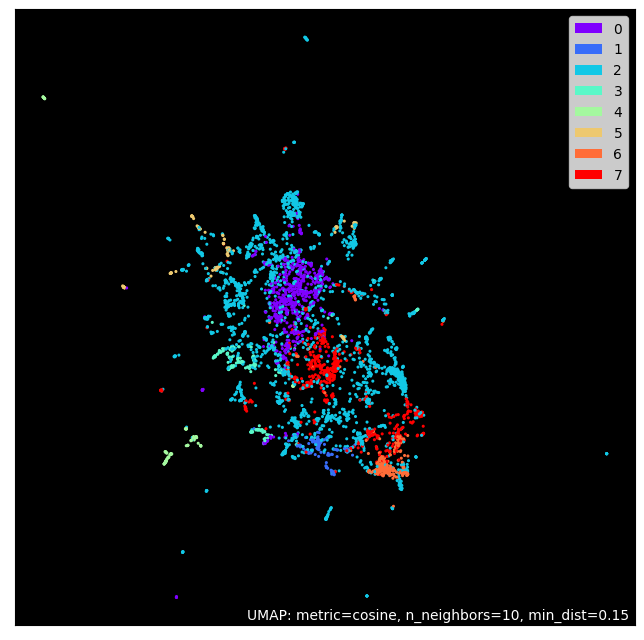

In [50]:
import umap.plot
umap.plot.points(mapper, labels=np.array(clusters.kmeans), theme='fire')
#plt.legend(loc=2)
umap.plot.plt.show()

## UMAP+DBSCAN

In [63]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.15, n_components=2, metric='cosine', n_epochs=50)
X_umap = reducer.fit_transform(tfidf_matrix)
umap_cl = hdbscan.HDBSCAN(min_cluster_size=75, min_samples=55).fit(X_umap.astype('float16'))

C:\Users\kater\anaconda3\envs\covid\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\kater\anaconda3\envs\covid\lib\site-packages\hdbscan\hdbscan_.py:275: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  alg = KDTreeBoruvkaAlgorithm(tree, min_samples, metric=metric,
C:\Users\kater\anaconda3\envs\covid\lib\site-packages\hdbscan\hdbscan_.py:56: DeprecationWarning: `np.int` is a deprec

In [64]:
clusters['umap'] = umap_cl.labels_
descriptions('umap', umap_cl.labels_)

C:\Users\kater\anaconda3\envs\covid\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cluster:  <built-in method title of str object at 0x0000013710354040>
Most popular words:  [('категорія', 3562), ('мова', 2217), ('вулиця', 1577), ('файл', 1556), ('місце', 1202), ('олександр', 1061), ('повіт', 1049), ('сільський', 945), ('герб', 914), ('право', 876)]
Total number of unique words:  78583


Cluster:  <built-in method title of str object at 0x000001370F7A1930>
Most popular words:  [('неуточнений', 858), ('новоутворення', 389), ('злоякісний', 303), ('порушення', 258), ('класифікований', 240), ('ураження', 220), ('уточнений', 183), ('гострий', 169), ('хронічний', 168), ('орган', 155)]
Total number of unique words:  4183


Cluster:  <built-in method title of str object at 0x000001370FC07E00>
Most popular words:  [('назва', 475), ('сільський', 370), ('поселення', 272), ('колишній', 257), ('хутір', 220), ('андріївка', 213), ('червоний', 133), ('чорний', 125), ('адміністративний', 107), ('селище', 105)]
Total number of unique words:  6725


Cluster:  <built-in method title of 

In [ ]:
def plot_2d(X, label_list_cluster):
    plt.figure(figsize=(7, 7))
    plt.subplots_adjust(bottom=0.1)
    c = label_list_cluster
    plt.scatter(X[:, 0], X[:, 1], c=c, cmap='rainbow', label='True Position')
    plt.show()

In [ ]:
plot_2d(X_umap,umap_cl.labels_)

# Pickle

In [65]:
import pickle

obj = {'clusters': clusters}
output = open('tfidf-clusters.pql', 'wb')
pickle.dump(obj, output, 2)
output.close()

C:\Users\kater\anaconda3\envs\covid\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
